# Part 2 : Histogram manipulation and equalisation

In this part of the TP, we are going to look at histogram equalisation. First, let us load the necessary packages and redefine some assistant functions. Note that in this part of TP, you can use the plt.imshow function, since we are not interested in the aliasing effects which might occur.

In [1]:
from matplotlib import pyplot as plt
import numpy as np 
import imageio.v2 as imageio
from skimage import color

is_colab= False

def read_image(file_name):
    img_color = imageio.imread(file_name)
    img_gray = color.rgb2gray(img_color)
    return img_gray,img_color
    
def write_image(img_in,file_name_out):
    imageio.imwrite(file_name_out, np.uint8(255.0*img_in))
    
def display_image(img_in):
    if (img_in.ndim == 2):
        plt.imshow(img_in,cmap='gray')
    elif (img_in.ndim == 3):
        # careful, in this case we supppose the pixel values are between 0 and 255
        plt.imshow(np.uint8(img_in))
    else:
        print('Error, unknown number of dimensions in image')
    return

(420, 570)

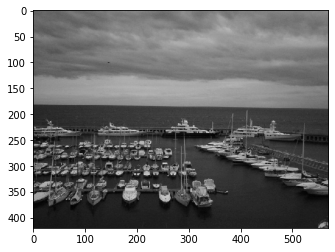

In [2]:
file_dir = 'images/'
file_name = 'boat'
file_ext = '.png'

if (is_colab == True):
  !wget "https://perso.telecom-paristech.fr/anewson/doc/images/boat.png"
  img_gray,_ = read_image(file_name+file_ext)
else:
  img_gray,_ = read_image(file_dir+file_name+file_ext)

display_image(img_gray)
img_gray.shape

As you can see, this image has pretty bad contrast : it is difficult to see in it. Now, display the histogram of this image to show this (you can use ```plt.hist```)

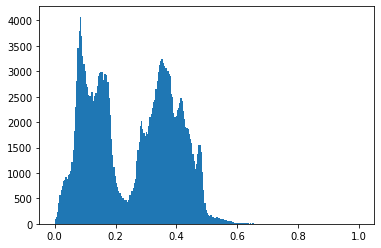

In [3]:
_ = plt.hist(img_gray.flatten(), bins=np.linspace(0,1,255))

You will notice that the histogram is not very well spread out over the whole range of the image. We are going to correct this in this part of the TP, by imposing a __uniform histogram__ on the image.

Firstly, calculate the cumulative histogram $H$ of the image and display it (use the ```np.histogram``` and ```np.cumsum``` functions).

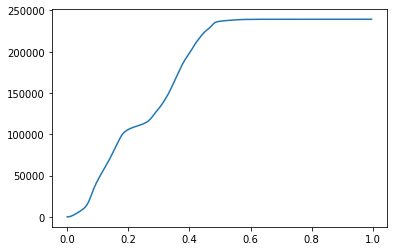

In [4]:
#INSERT CODE HERE

hist_vals, hist_bins = np.histogram(img_gray.flatten(), bins=np.linspace(0,1,255))
cum_hist = np.cumsum(hist_vals)
plt.plot(hist_bins[0:-1],cum_hist)

## Histogram equalisation

Now, if we apply the cumulative histogram $H$ as a contrast change, then we are imposing a uniform histogram on the image (see the lesson slides). A contrast change means we do not change the order of the __values__ of the pixels. We are going to use $H$ as a type of lookup table to find the new values of the image.

In practice, this can be done with the following method :

- normalise the cumulative histogram such that the largest value is 1.0. This will map the final image to the interval $0, \dots, 1$
- convert the image grey-levels back to the interval $\{0, \dots 255\}$ as int values (use np.floor). This will allow us to use these values as indices in H
- apply the cumulative histogram to the values of the image pixels

Implement this algorithm now in a function ``equalize_histogram``. __Note__ In the ``np.histogram`` function, the histogram values have one less element than the histogram bins

In [5]:
from itertools import product

In [6]:
def equalize_histogram(img_in: np.array):
    #INSERT CODE HERE
    hist_vals, hist_bins = np.histogram(img_in.flatten(), bins=np.linspace(0,1,257))
    H = np.cumsum(hist_vals).astype(float)
    # print(H.shape)
    H -= H.min()
    H /= H.max()
    # img_equalise = np.array([[H[int(img_in[i][j]*255)] for j in range(img_in.shape[1])] for i in range(img_in.shape[0])])

    indices = np.round(img_in * (H.shape[0]-1)).astype(int)
    img_equalise = img_in
    for (i,j) in product(range(img_in.shape[0]) , range(img_in.shape[1])):
        img_equalise[i,j] = H[indices[i,j]]
    return img_equalise

We carry out the algorithm on the input image and display the image. Is the result better ?

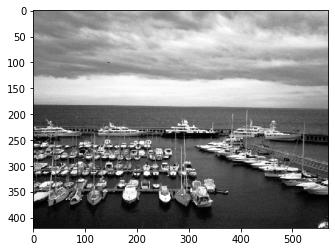

In [7]:
img_gray_equalise = equalize_histogram(img_gray)
display_image(img_gray_equalise)

Now, display both the histogram and cumulative histogram of the equalised image

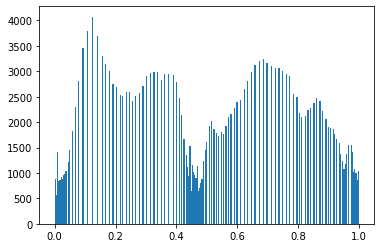

In [8]:
#INSERT CODE HERE
_ = plt.hist(img_gray_equalise.flatten(), bins=np.linspace(0,1,254))

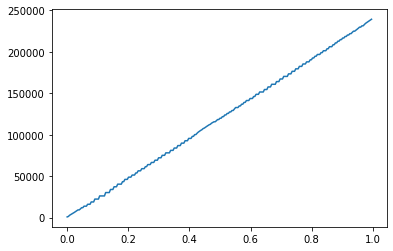

In [9]:
hist_vals, hist_bins = np.histogram(img_gray_equalise.flatten(), bins=np.linspace(0,1,255))
cum_hist = np.cumsum(hist_vals)
plt.plot(hist_bins[0:-1],cum_hist)

__Question 2.1__ Is the histogram of the equalised image perfectly uniform (flat) ? Why is this the case ?

__Answer__ No, since the we are actually deal with a discrete version of uniform distribution where we have discontinuities, and some bins contains more pixels than others.

### Colour images

Let us try to apply our algorithm to a colour image. First, let's read the image and display it

(761, 1142, 3)

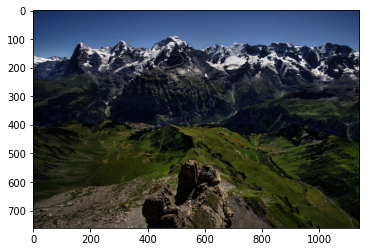

In [10]:
file_dir = 'images/'
file_name = 'alps_contrast'
file_ext = '.png'

if (is_colab == True):
  !wget "https://perso.telecom-paristech.fr/anewson/doc/images/alps_contrast.png"
  _,img_color = read_image(file_name+file_ext)
else:
  _,img_color = read_image(file_dir+file_name+file_ext)

display_image(img_color)
img_color.shape

In [11]:
img_color[:,:,0].shape

(761, 1142)

Now, create a function ``equalize_histogram_color`` which uses your grey-level function to carry out colour histogram equalisation in each colour channel independently, and display the output image. Careful to

- normalise the input range to $0, \dots, 1$ for each channel when processing it
- put the output range back to $0, \dots, 255$ when displaying.

To view the result better, you can write it to a file.

3


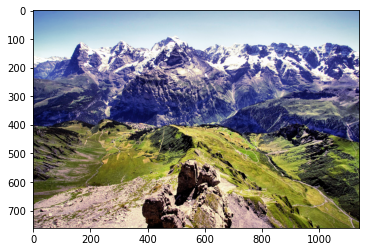

In [13]:
def equalize_histogram_color(img_color):
    #INSERT CODE HERE
    img_c = [img_color[:,:,i]/255 for i in range(img_color.shape[2])]
    print(len(img_c))
    img_e = [equalize_histogram(img) for img in img_c]
    img_color_equalized = np.stack(img_e, axis=-1)
    
    return img_color_equalized


img_color_equalized = equalize_histogram_color(img_color)
display_image(255.0 * img_color_equalized)

write_image(img_color_equalized,file_name+'_equalised.png')

__Question 1.2__ Do you think this result looks right ? What may be wrong in our approach ? What could be a solution to this ?

__Answer__: not exactly, for example the mountain becomes somehow purple and the grass becomes yellow. Maybe it's because that simply equalize histogram of colors on each RGB channels changes the actual distribution of the color. However what we want is only enlarge the contrast(i.e. the saturation and the brightness and not change the choromacity) We may try to deal it in HSV space

In [15]:
from skimage.color import rgb2hsv, hsv2rgb

In [16]:
img_hsv = rgb2hsv(img_color)

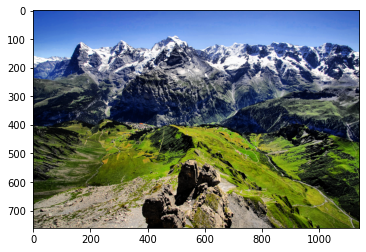

In [19]:
def equalize_histogram_color_in_hsv(img_color):
    #INSERT CODE HERE
    # pixels are nomarlized in hsv
    img_hsv = rgb2hsv(img_color)
    h = img_hsv[:,:,0] # don't change chromacity
    s = equalize_histogram(img_hsv[:,:,1])  
    v = equalize_histogram(img_hsv[:,:,2])  
    
    img_color_equalized = hsv2rgb(np.stack([h,s,v], axis=-1))
    return img_color_equalized


img_color_equalized = equalize_histogram_color_in_hsv(img_color)
display_image(255.0 * img_color_equalized)

write_image(img_color_equalized,file_name+'_equalised_in_hsv.png')